# Smoke Detection
Use Transfer Learning to detect smoke in an image

In [1]:
from preprocess_img import get_preprocessed_img
from train import train
from evaluation import get_evaluation
from keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline

## Load the image dataset

In [2]:
!ls /input

1  2  3  4  5


### Set the dataset path

In [3]:
dataset_path = '/input/1'

['.DS_Store', 'non', 'smoke']


### Get the image

In [4]:
smoke_img, nonsmoke_img = get_preprocessed_img(dataset_path)

### Get an image for check

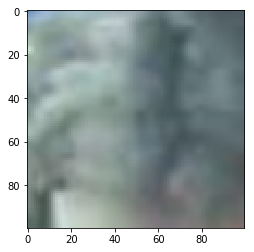

In [5]:
plt.figure
plt.subplot(121)
plt.imshow(smoke_img[0])
plt.subplot(122)
plt.imshow(nonsmoke_img[0])

In [11]:
print("smoke image shape: {}".format(smoke_img.shape))
print("non smoke image shape: {}".format(nonsmoke_img.shape))

resized smoke image shape: (552, 224, 224, 3)
resized non smoke image shape: (831, 224, 224, 3)


### Generate labels
**1** for **smoke image** and **0** for **non smoke image**

In [12]:
smoke_labels = np.ones(smoke_img.shape[0], dtype=np.int8)
nonsmoke_labels = np.zeros(nonsmoke_img.shape[0], dtype=np.int8)

### Split the dataset to train, validation sets

In [13]:
smoke_pos = int(smoke_img.shape[0] * 0.8)
nonsmoke_pos = int(nonsmoke_img.shape[0] * 0.8)

X_train = np.concatenate((smoke_img[:smoke_pos], nonsmoke_img[:nonsmoke_pos]))
y_train = np.concatenate((smoke_labels[:smoke_pos], nonsmoke_labels[:nonsmoke_pos]))

X_validation = np.concatenate((smoke_img[smoke_pos:], nonsmoke_img[nonsmoke_pos:]))
y_validation = np.concatenate((smoke_labels[smoke_pos:], nonsmoke_labels[nonsmoke_pos:]))

## Train the model

In [ ]:
train(X_train, y_train, X_validation, y_validation)

## Evaluation

### Set the test image path

In [36]:
test_dataset_path = '/input/5'

### load the model

In [ ]:
model = load_model('smoke_detection.h5') 

In [ ]:
test_smoke_img, test_nonsmoke_img = get_preprocessed_img(test_dataset_path)
dr, far, acr = get_evaluation(test_smoke_img, test_nonsmoke_img, model)

In [ ]:
print('detect rate:{}'.format(dr))
print('false alarm rate:{}'.format(far))
print('accuracy:{}'.format(acr))

## Predict some images

In [22]:
test_img_path = './test-img/2.jpg'

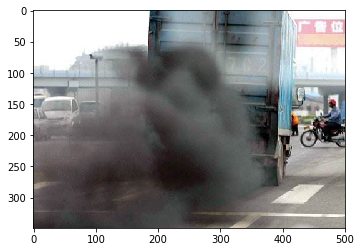

In [23]:
test_img = plt.imread(test_img_path)
plt.imshow(test_img)

In [24]:
model.predict(resize_img(test_img).reshape([1, 224, 224, 3]))

array([[ 0.]], dtype=float32)

In [25]:
test_smoke_part = test_img[200:350, 0:300]

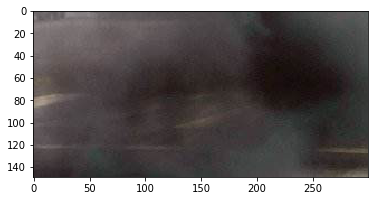

In [26]:
plt.imshow(test_smoke_part)

In [27]:
model.predict(resize_img(test_smoke_part).reshape([1, 224, 224, 3]))

array([[ 0.]], dtype=float32)

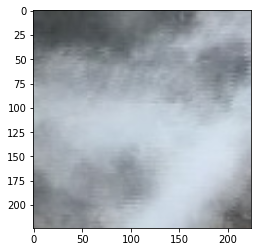

In [28]:
plt.imshow(X_test[10])

In [29]:
model.predict(X_test[10].reshape([1, 224, 224, 3]))

array([[ 1.]], dtype=float32)

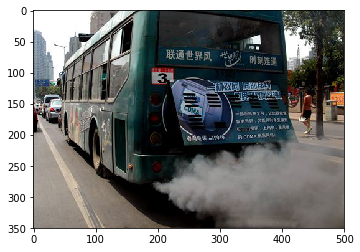

In [30]:
test_img_path = './test-img/4.jpg'
test_img = plt.imread(test_img_path)
plt.imshow(test_img)

In [31]:
model.predict(resize_img(test_img).reshape([1, 224, 224, 3]))

array([[ 0.]], dtype=float32)

In [32]:
test_smoke_part = test_img[250:350, 220:500]

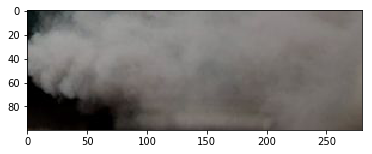

In [33]:
plt.imshow(test_smoke_part)

In [35]:
model.predict(resize_img(test_smoke_part).reshape([1, 224, 224, 3]))

array([[ 1.]], dtype=float32)

## Detect smoke in image

### Define some help functions

In [57]:
def get_prediction(img, model):
    resized_img = resize_img(img).reshape([1, 224, 224, 3])
    prediction = model.predict(resized_img)
    return int(prediction)

In [58]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [59]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [60]:
def detect_smoke(img, model):
    # Get all the windows to be searched
    window_list = slide_window(img)
    # Will store the suspected smoke region
    smoke_regions = []
    for window in window_list:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        prediction = get_prediction(test_img, model)
        if prediction == 1:
            smoke_regions.append(window)
    smoke_img = draw_boxes(img, smoke_regions)
    return smoke_img

### Pick up one to test the function

In [41]:
test_path = './test-img'
test_img_paths = os.listdir(test_path)
test_img_paths = [os.path.join(test_path, path) for path in test_img_paths]

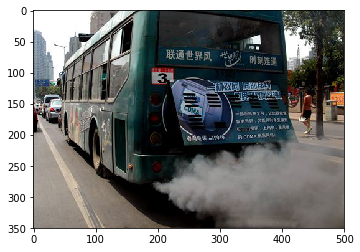

In [48]:
img = plt.imread(test_img_paths[4])
plt.imshow(img)

In [49]:
window_list = slide_window(img)
len(window_list)

104

In [53]:
smoke_regions = []
for window in window_list:
    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    prediction = get_prediction(test_img, model)
    if prediction == 1:
        smoke_regions.append(window)

In [54]:
smoke_regions

[((192, 224), (256, 288)),
 ((224, 224), (288, 288)),
 ((256, 224), (320, 288)),
 ((288, 224), (352, 288)),
 ((320, 224), (384, 288)),
 ((352, 224), (416, 288))]

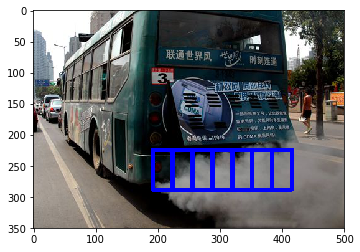

In [55]:
plt.imshow(draw_boxes(img, smoke_regions))

### Get all the test images

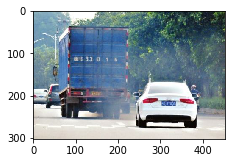

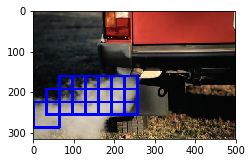

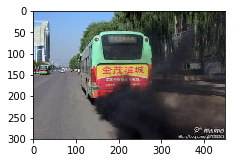

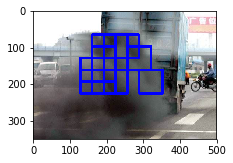

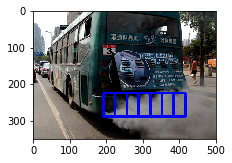

In [61]:
for index, img_path in enumerate(test_img_paths, 1):
    img = plt.imread(img_path)
    smoke_img = detect_smoke(img, model)
    plt.figure(figsize=(16,8))
    plt.subplot(3,2,index)
    plt.imshow(smoke_img)